In [1]:
import os
import sys
import json
import glob
import h5py
import tqdm
import time
import numpy as np
import scipy.signal
import scipy.interpolate
import scipy.io
import scipy.io.wavfile
import soundfile as sf
import soxr
import matlab.engine

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc


In [2]:
eng = matlab.engine.start_matlab();
eng.addpath('HRTFs/');


In [93]:
def room_impulse_hrtf(
        src_loc,
        head_center,
        head_azimuth,
        walls,
        wtypes,
        meas_sym=1,
        f_samp=44100,
        c_snd=344.5,
        num_taps=22050,
        log_dist=0,
        jitter=1,
        highpass=1,
        dsply=0,
        eng=None):
    """
    """
    meas_locs = eng.load('HRTFs/data_locs.mat')['locs_gardnermartin']
    meas_files = eng.cellstr(scipy.io.loadmat('HRTFs/file_names.mat')['gardnermartin_file'].tolist())
    meas_delay = (np.sqrt(np.sum(np.square(src_loc - head_center))) / c_snd) * np.ones(len(meas_files))
    h_out, lead_zeros = eng.room_impulse_hrtf(
        matlab.double(src_loc.reshape([1, 3]).tolist()),
        matlab.double(head_center.reshape([1, 3]).tolist()),
        matlab.double([head_azimuth]),
        meas_locs,
        meas_files,
        matlab.double(meas_delay.reshape([len(meas_files), 1]).tolist()),
        matlab.double([meas_sym]),
        matlab.double(walls.reshape([1, 3]).tolist()),
        matlab.double(np.array([wtypes]).tolist()),
        matlab.double([f_samp]),
        matlab.double([c_snd]),
        matlab.double([num_taps]),
        matlab.double([log_dist]),
        matlab.double([jitter]),
        matlab.double([highpass]),
        matlab.double([dsply]),
        nargout=2)
    h_out = np.array(h_out)
    lead_zeros = np.array(lead_zeros)
    print(f'LEAD_ZEROS={lead_zeros}')
    return h_out


def is_valid_position(point, walls, buffer=0):
    assert len(point) == len(walls)
    for p, w in zip(point, walls):
        if p < buffer or p > w - buffer:
            return False
    return True


def get_brir(room_materials=[26, 26, 26, 26, 26, 26],
             room_dim_xyz=[10, 10, 10],
             head_pos_xyz=[5, 5, 5],
             head_azim=0,
             src_azim=0,
             src_elev=0,
             src_dist=1,
             buffer_pos=0,
             sr=44100,
             dur=0.5,
             eng=None):
    """
    """
    assert head_azim >= -135, "head_azim < -135 degrees cause unexpected behavior"
    room_materials = np.array(room_materials)
    assert room_materials.shape == (6,)
    room_dim_xyz = np.array(room_dim_xyz)
    assert room_dim_xyz.shape == (3,)
    head_pos_xyz = np.array(head_pos_xyz)
    assert head_pos_xyz.shape == (3,)
    src_pos_xyz = np.array([
        src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
        src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
        src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
    ])
    assert is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid head position"
    assert is_valid_position(src_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid source position"
    print(f"Running room simulator: head={head_pos_xyz}, src={src_pos_xyz}, room={room_dim_xyz}")
    t0 = time.time()
    brir = room_impulse_hrtf(
        src_loc=src_pos_xyz,
        head_center=head_pos_xyz,
        head_azimuth=-head_azim, # `room_impulse_hrtf` convention is positive azimuth = clockwise
        walls=room_dim_xyz,
        wtypes=room_materials,
        meas_sym=1,
        f_samp=sr,
        c_snd=344.5,
        num_taps=int(dur * sr),
        log_dist=0,
        jitter=1,
        highpass=1,
        dsply=0,
        eng=eng)
    print(f'Ran room simulator in {time.time() - t0} seconds')
    return brir


In [109]:
brir = get_brir(
    room_materials=[26] * 6,
    room_dim_xyz=[10, 10, 10],
    head_pos_xyz=[5, 5, 5],
    head_azim=0,
    src_azim=-45,
    src_elev=0,
    src_dist=1.4,
    buffer_pos=1,
    sr=44100,
    dur=0.5,
    eng=eng)

brir_near = get_brir(
    room_materials=[26] * 6,
    room_dim_xyz=[10, 10, 10],
    head_pos_xyz=[5, 5, 5],
    head_azim=0,
    src_azim=25,
    src_elev=0,
    src_dist=1.4,
    buffer_pos=1,
    sr=44100,
    dur=0.5,
    eng=eng)


Running room simulator: head=[5 5 5], src=[5.98994949 4.01005051 5.        ], room=[10 10 10]
LEAD_ZEROS=0.004063860667634252
Ran room simulator in 3.8213188648223877 seconds
Running room simulator: head=[5 5 5], src=[6.2688309  5.59166557 5.        ], room=[10 10 10]
LEAD_ZEROS=-0.9959361393323658
Ran room simulator in 3.0382726192474365 seconds


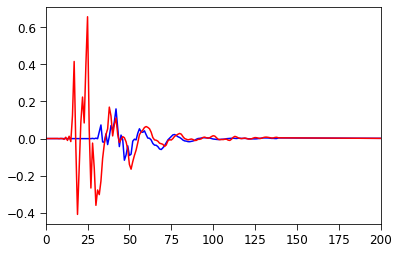

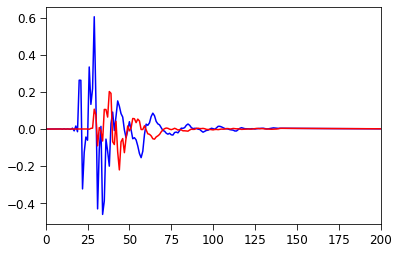

In [110]:
fig, ax = plt.subplots()
ax.plot(brir[:, 0], 'b')
ax.plot(brir[:, 1], 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 200])
plt.show()

fig, ax = plt.subplots()
ax.plot(brir_near[:, 0], 'b')
ax.plot(brir_near[:, 1], 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 200])
plt.show()


In [65]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/001.wav'
y, sr = sf.read(fn)
y = np.random.randn(*y.shape)
t = np.arange(0, len(y)) / sr
y = (np.sin(2 * np.pi * 2 * t) > 0) * y
ipd.display(ipd.Audio(rate=sr, data=y))
print(sr, y.shape)


44100 (132300,)


In [111]:
y_spatial = util_stimuli.spatialize_sound(y, brir)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T))

y_spatial = util_stimuli.spatialize_sound(y, brir_near)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T))


(22050, 2) float64 (132300, 2) float64


(22050, 2) float64 (132300, 2) float64


In [128]:
map_material_to_int = {
    'Brick': 1,
    'Concrete, painted': 2,
    'Window Glass': 3,
    'Marble': 4,
    'Plaster on Concrete': 5,
    'Plywood': 6,
    'Concrete block, coarse': 7,
    'Heavyweight drapery': 8,
    'Fiberglass wall treatment, 1 in': 9,
    'Fiberglass wall treatment, 7 in': 10,
    'Wood panelling on glass fiber blanket': 11,
    
    'Wood parquet on concrete': 12,
    'Linoleum': 13,
    'Carpet on concrete': 14,
    'Carpet on foam rubber padding': 15,
    
    'Plaster, gypsum, or lime on lath': 16,
    'Acoustic tiles, 0.625", 16" below ceiling': 17,
    'Acoustic tiles, 0.5", 16" below ceiling': 18,
    'Acoustic tiles, 0.5" cemented to ceiling': 19,
    'Highly absorptive panels, 1", 16" below ceiling': 20,
    
    'Upholstered seats': 21,
    'Audience in upholstered seats': 22,
    'Grass': 23,
    'Soil': 24,
    'Water surface': 25,
    'Anechoic': 26,
    'Uniform (0.6) absorbtion coefficient': 27,
    'Uniform (0.2) absorbtion coefficient': 28,
    'Uniform (0.8) absorbtion coefficient': 29,
    'Uniform (0.14) absorbtion coefficient': 30,
    'Artificial - absorbs more at high freqs': 31,
    'Artificial with absorption higher in middle ranges': 32,
    'Artificial  - absorbs more at low freqs': 33,
}
map_int_to_material = {v: k for k, v in map_material_to_int.items()}


def sample_room_parameters():
    is_outdoor = np.random.choice([0, 1], p=[0.75, 0.25])
    x_len = np.exp(np.random.uniform(low=np.log(2), high=np.log(100), size=None))
    y_len = np.exp(np.random.uniform(low=np.log(2), high=np.log(100), size=None))
    z_len = np.exp(np.random.uniform(low=np.log(2), high=np.log(20), size=None))
    
    if is_outdoor:
        material_floor = np.random.choice([1, 7, 23, 24, 25])
        material_ceiling = np.random.choice([26])
        material_wall = np.random.choice([26, -1], size=4, replace=True, p=[0.75, 0.25])
        IDX_outdoor_wall = material_wall < 0
        material_wall[IDX_outdoor_wall] = np.random.choice(
            [1, 2, 3, 4, 5, 6, 7],
            size=IDX_outdoor_wall.sum(),
            replace=True)
    else:
        material_floor = np.random.choice([1, 2, 4, 6, 12, 13, 14, 15])
        material_ceiling = np.random.choice([3, 6, 16, 17, 18, 19, 20])
        n_max_wall_materials = np.random.choice([1, 2, 3, 4])
        material_wall = np.random.choice(
            np.random.choice(
                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                size=n_max_wall_materials,
                replace=False),
            size=4,
            replace=True)
    print(f"Sampled room: {[x_len, y_len, z_len]}")
    print(f"|__ floor: {map_int_to_material[material_floor]}")
    print(f"|__ ceiling: {map_int_to_material[material_ceiling]}")
    for _ in range(4):
        print(f"|__ wall_{_}: {map_int_to_material[material_wall[_]]}")

for _ in range(20):
    sample_room_parameters()


Sampled room: [2.671345459248893, 12.927446073167713, 2.9375963180533726]
|__ floor: Water surface
|__ ceiling: Anechoic
|__ wall_0: Marble
|__ wall_1: Anechoic
|__ wall_2: Anechoic
|__ wall_3: Anechoic
Sampled room: [12.394005567872295, 60.64438053922274, 18.194067541362426]
|__ floor: Brick
|__ ceiling: Acoustic tiles, 0.625", 16" below ceiling
|__ wall_0: Concrete, painted
|__ wall_1: Concrete, painted
|__ wall_2: Concrete, painted
|__ wall_3: Concrete, painted
Sampled room: [72.74770657637204, 10.084260398164428, 14.600992023331488]
|__ floor: Brick
|__ ceiling: Anechoic
|__ wall_0: Anechoic
|__ wall_1: Brick
|__ wall_2: Anechoic
|__ wall_3: Anechoic
Sampled room: [40.26045289437863, 17.47631263880064, 6.385814859424214]
|__ floor: Concrete block, coarse
|__ ceiling: Anechoic
|__ wall_0: Anechoic
|__ wall_1: Window Glass
|__ wall_2: Anechoic
|__ wall_3: Anechoic
Sampled room: [75.36271207533353, 20.491551003594306, 2.9622595643159317]
|__ floor: Brick
|__ ceiling: Plywood
|__ wall_

In [137]:
eng.quit()
